# 2D (x-t) field generation and lagrangian simulation

This example will cover:

 - Generation of a synthetic x-t field
 - Advection of sample drifters
 
 
Prerequisite, have parcels installed, see [OceanParcels doc](https://oceanparcels.org).
If under conda environment: `conda install -c conda-forge parcels`


In [1]:
from gptide import cov
from gptide import GPtideScipy

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

from scipy import stats
from gptide import stats as gpstats

## Generate some data

In [2]:
####
# These are our kernel input parameters
np.random.seed(1)
noise = 0.01
#η = 10 
η = .2 # 
ℓ_x = 100e3 # meters
ℓ_t = 86400*5 # seconds

###
# Domain size parameters
Nx = 1000
Nt = 24*60
# output grid spacing
dx = 1000.
dt = 3600.

t_x = np.arange(Nx)[:, None]*dx
t_t = np.arange(Nt)[:, None]*dt

Cov_x = cov.matern32(t_x, t_x.T, ℓ_x) + noise * np.eye(Nx)
Cov_t = cov.matern32(t_t, t_t.T, ℓ_t) + noise * np.eye(Nt)
#Cov_t = cov.matern32(t_t, t_t.T, ℓ_t) * cov.cosine(t_t, t_t.T, 86400/2) + noise * np.eye(Nt)

Text(0.5, 1.0, 't Covariance')

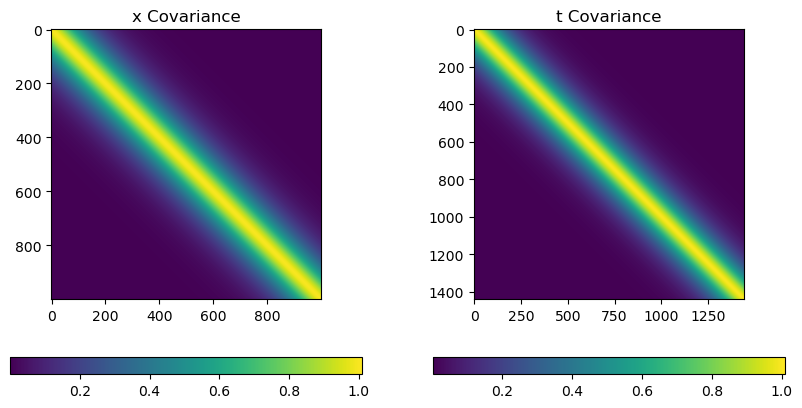

In [3]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

ax = axes[0]
h = ax.imshow(Cov_x)
plt.colorbar(h, location="bottom")
ax.set_title("x Covariance")

ax = axes[1]
h = ax.imshow(Cov_t)
plt.colorbar(h, location="bottom")
ax.set_title("t Covariance")

In [4]:
# Input data points
xd = np.arange(0,dx*Nx,dx)[:,None]-dx/2
td = np.arange(0,dt*Nt,dt)[:,None]-dt/2

## Cholesky decomposition and sample generation

In [5]:
Ls = np.linalg.cholesky(Cov_x)
Lt = np.linalg.cholesky(Cov_t)

# generate sample
V = np.random.normal(size = Nx * Nt).reshape((Nx, Nt))
zg = η * Ls @ V @ Lt.T

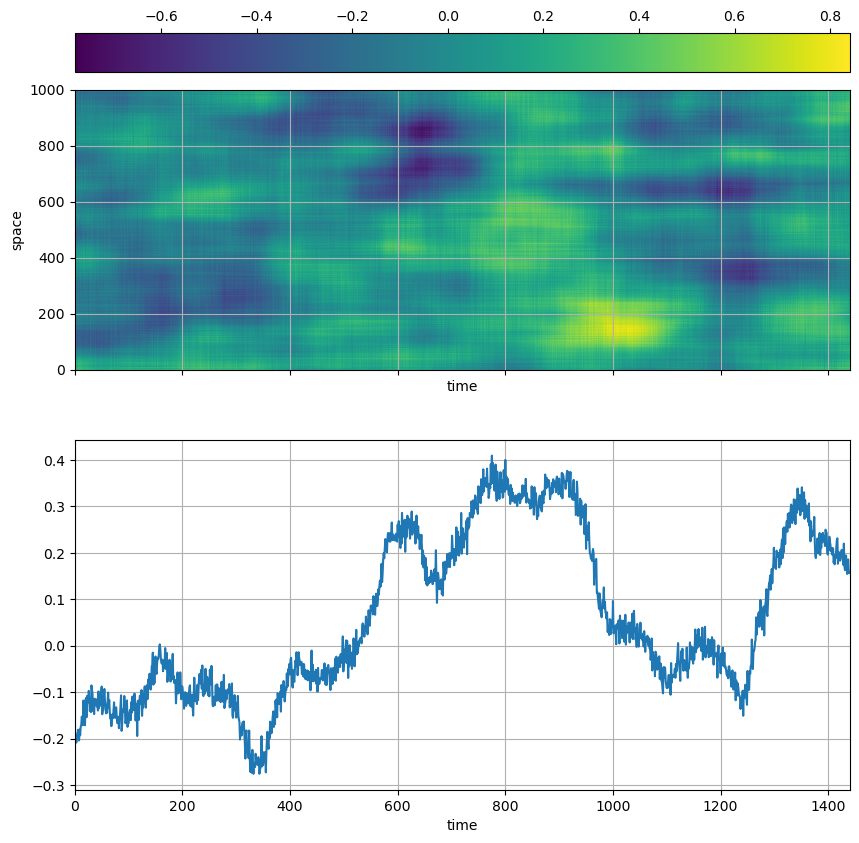

In [6]:
fig, axes = plt.subplots(2,1,figsize=(10,10), sharex=True)
ax = axes[0]
h = ax.pcolormesh(zg)
ax.set_xlabel("time")
ax.set_ylabel("space")
ax.grid()
plt.colorbar(h, location="top")
ax = axes[1]
#fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(zg[Nx//2, :])
ax.set_xlabel("time")
ax.grid()

## setup parcels

In [7]:
from datetime import timedelta

import xarray as xr

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    plotTrajectoriesFile,
)

In [36]:
ds = xr.Dataset(dict(U=(("time", "lon"), zg.T)), 
                coords=dict(lon=("lon", xd.squeeze()),
                            lat=("lat", np.arange(-1,2)),
                            time=("time", td.squeeze()),
                           ),
               )
ds["U"] = ds["U"] + ds.lat*0.
ds["V"] = ds["U"]*0.

buffer = (dx*2, float(xd[-1])-2*dx)
ds["U"] = ds["U"].where( (ds["lon"]>buffer[0]) & (ds["lon"]<buffer[1]) )
ds["V"] = ds["V"].where( (ds["lon"]>buffer[0]) & (ds["lon"]<buffer[1]) )

ds["time"].attrs["units"] = "seconds"
ds = ds.transpose("time", "lat", "lon")

ds_in = ds

In [22]:
fieldset = FieldSet.from_xarray_dataset(
    ds,
    variables=dict(U="U", V="V"),
    dimensions=dict(lon="lon", lat="lat", time="time"),                         
    mesh="flat",
)

In [10]:
x0 = xd[1:-1].squeeze()
y0 = x0*0
#t0 = x0*0. + td[1]

In [11]:
pset = ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=x0,  # a vector of release longitudes
    lat=y0,  # a vector of release latitudes
    #time=t0,
)

In [12]:
#print(pset)

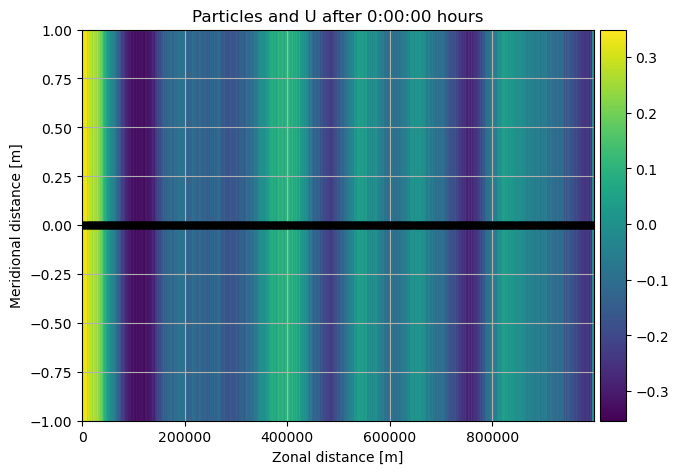

In [13]:
pset.show(field=fieldset.U)

In [14]:
zarr = "EddyParticles.zarr"

In [15]:
output_file = pset.ParticleFile(
    name=zarr,  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)

Tmax = np.floor(td.max()/86400)

pset.execute(
    AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=Tmax),  # the total length of the run
    dt=timedelta(minutes=30),  # the timestep of the kernel
    #dt=timedelta(minutes=30),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/parcels-501/lib6195d48a146d29c0ac96ce341406472c_0.so
INFO: Output files are stored in EddyParticles.zarr.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5097600.0/5097600.0 [03:28<00:00, 24465.54it/s]


### reload and plot

In [37]:
def fix_spatial_coords(ds):
    ds = ds.rename(lon="x", lat="y")
    ds["x"] = ds["x"]/1e3
    ds["y"] = ds["y"]/1e3
    ds.x.attrs.update(units="kilometers", standard_name="x")
    ds.y.attrs.update(units="kilometers", standard_name="y")
    if "t" in ds:
        ds.t.attrs.update(units="days")
    else:
        # ds_in, time is in seconds
        ds["time"] = ds["time"]/86400
        ds.time.attrs.update(units="days")
    return ds

In [38]:
ds = xr.open_zarr("EddyParticles.zarr")
ds = ds.assign_coords(t=(ds["time"] - ds["time"][0,0])/pd.Timedelta("1D"))
ds = fix_spatial_coords(ds)

ds_in = fix_spatial_coords(ds_in)
ds_in.U.attrs.update(units="m/s")

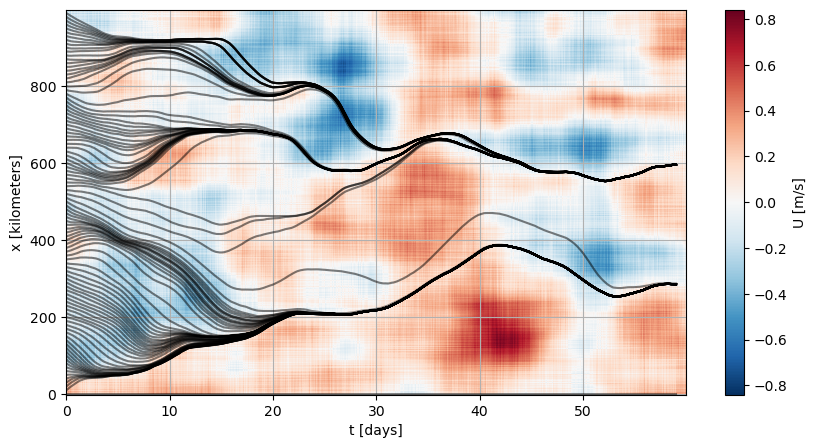

In [51]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ds_in.U.isel(y=0).plot(ax=ax, x="time")
ds["x"].isel(trajectory=slice(0,None,10)).plot(ax=ax, x="t", hue="trajectory", color="k", add_legend=False, alpha=0.5);
#ax.set_xlabel("time")
#ax.set_ylabel("space")
ax.grid()